## Kaytoo | Inference Notebook

### Bird Call Classification for New Zealand birds

## Basic Setup
Adjust the dictionary below for the overall notebook use case.

In [271]:
notebook_use = {
                'experiment': 2,
                'folder_to_process': '/media/olly/T7/Kaytoo/Data/Soundscapes/DOC_Tier1_2011/',
                'kaytoo_root_folder': '/media/olly/T7/Kaytoo/',
                'model_choices': [0],
                'cpu-only': True
                }

Text colour classes

## Library Imports

In [272]:
#General Python
from pathlib import Path
from tqdm.notebook import tqdm
import json
from joblib import Parallel, delayed
import os

#Math & Plotting
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

#Machine Learning 
import albumentations as A

#Torch and PyTorch specific
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import  DataLoader, Dataset
from torchaudio.functional import compute_deltas

#Audio
import librosa
import torchaudio

print('Imports Complete')

Imports Complete


## Configuration Classes

In [273]:
class DefaultConfig:
    def __init__(self, paths, options=None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        if options:
            if options['cpu-only']:
                self.device = torch.device('cpu')

        with open(paths.EBIRD_LIST_PATH, 'r') as file:
            ebird_list = json.load(file)
        self.classes = ebird_list

In [274]:
class AudioParameters:
    def __init__(self):
        self.SR = 32000
        self.FMIN = 20
        self.FMAX = 14000 

In [275]:
class ModelParameters:
   def __init__(self, options=None):
        self.parameters = [
        {'basename':'tf_efficientnet_b0.ns_jft_in1k',  #Exp_116 LB66, 43 minutes, uses Googlebirds_25 for 7 epochs
                         'ckpt_path': '/media/olly/T7/Kaytoo/Data/Experiments/Exp_2/Results/epoch=12-step=68337.ckpt',
                         'image_shape': (1,2), #The layout of 5-sec spectrograms stacked into the final image (height x width)
                         'image_time': 10,
                         'n_mels': 256,
                         'n_fft': 2048,
                         'use_deltas' : True,
                         'hop_length': 1243,
                         '5_sec_width': 128,
                         'aggregation': 'mean',
                         }, 
        ]
        if options and options.get('model_choice'):
            model_choices = options['model_choice']
            _parameters_list = [_parameters_list[i] for i in model_choices] 

In [276]:
class Models:
    def prep_model(self, cfg, kwargs):
        device = cfg.device
        bird_list = cfg.classes
        path = kwargs['ckpt_path']
        
        if device == torch.device('cpu'):
            ckpt = torch.load(path, map_location='cpu')
        else:
            ckpt = torch.load(path, map_location='cuda') #["model_state_dict"]
            
        model = BirdSoundModel(bird_list, kwargs)
        model.load_state_dict(ckpt) #["model_state_dict"]
        model.eval()
        model = model.to(device)
        return model     

    def __init__(self, config, model_parameters, audio_parameters):
        self.parameters = model_parameters.parameters
        self.models = [self.prep_model(config, args_dict) for args_dict in self.parameters]
        self.audio = audio_parameters
        self.ebirds = config.classes
        self.device = config.device


In [277]:
class FilePaths:
    def __init__(self, options=None):
        self.EXPERIMENT = 2
        self.PROJECT_DIR = Path(options.get('kaytoo_root_folder'))
        self.DATA_DIR = self.PROJECT_DIR / 'Data'
        self.EXPERIMENT_DIR = self.DATA_DIR / 'Experiments' / f'Exp_{self.EXPERIMENT}'
        self.WEIGHTS_PATH = str(self.EXPERIMENT_DIR / 'Results' / f'exp_{self.EXPERIMENT_DIR}_best_weights.ckpt')
        self.EBIRD_LIST_PATH = str(self.EXPERIMENT_DIR / 'Results' / 'ebird_list.json')
        self.SOUNDSCAPE_FLDR = Path(options['folder_to_process'])
        audio_types = {'.ogg','.wav', '.flac', '.mp3'}
        self.soundscapes = [path for path in self.SOUNDSCAPE_FLDR.rglob('*') if path.suffix in audio_types]
        self.PREDICTIONS_CSV = self.SOUNDSCAPE_FLDR / 'predictions.csv'

## Helper Functions and Classes

In [278]:
def open_audio_clip(path):   
    #Modify this to re-sample anything not using 32,000 sample rate
    try:  
        y, sr = torchaudio.load(path)
        if y.ndim == 2 and y.shape[0] == 2:
            y = torch.mean(y, dim=0).unsqueeze(0)  # from stereo to mono
        y = y.squeeze().numpy() 
    except:
        y = np.random.randn(5*320000) 
        print(f'could not open {path}')
    
    if not np.isfinite(y).all():
        y[np.isnan(y)] = np.zeros_like(y)
        y[np.isinf(y)] = np.max(y)
    return y


def get_images(audio_path, #PathLib Path object
               model_params,
               audio_params,
               clip_length=None,
               sr=32000):
    
    hop_length = model_params['hop_length']
    n_mels = model_params['n_mels']
    n_fft = model_params['n_fft']
    chunk_width = model_params['5_sec_width']
    num_chunks = model_params['image_shape'][0] * model_params['image_shape'][1]
    chunk_length = model_params['image_time']//(num_chunks)
    prep_image = PrepareImage(height=n_mels, width=chunk_width)


    idxs  = []
    image_dict = {}
    _y = open_audio_clip(audio_path)
    if clip_length is None:
        clip_length = len(_y) // sr

    for index in range(0, clip_length // chunk_length):
        idxs.append(index)
        start = index * chunk_length
        stop = start + chunk_length
        start_idx = sr * start
        stop_idx =  sr * stop
        
        if stop_idx > len(_y):
            y = _y[start_idx:]
            remaining_length = stop_idx - len(_y)  # Calculate how much we need to fill
            noise = np.random.randn(remaining_length) * np.std(_y)
            y = np.concatenate((y, noise))
        else: 
            y = _y[start_idx: stop_idx]
        
        max_vol = np.abs(y).max()
        y = y * 1 / max_vol    #y, sr, hop_length, n_mels, n_fft, audio_params
        image = compute_melspec(y, sr, hop_length, n_mels, n_fft, audio_params)
        image = prep_image.prep(image=image)['image']
        image_dict[index] = image
        
    num_specs = len(image_dict)
    extra_specs = clip_length % num_chunks  #Handle the case where there are more spectrograms needed to make up the combined image
    if extra_specs:
        noise = np.random.randn(chunk_length * sr)
        image = compute_melspec(noise, sr, hop_length, n_mels, n_fft, audio_params)
        image = prep_image.prep(image=image)['image']
        for extra_idx in range(num_specs+1, num_specs+extra_specs+1):
            image_dict[extra_idx] = image


    return image_dict, extra_specs  #a dict of images, with keys from 0 to 47 for the case of a 240 second clip.

In [279]:

def compute_melspec(y, sr, hop_length, n_mels, n_fft, audio_params):
    if audio_params:
        fmin = audio_params.FMIN
        fmax = audio_params.FMAX
    else:
        fmin = 40
        fmax = 14000

    melspec = librosa.feature.melspectrogram(y=y, 
                                             sr=sr, 
                                             n_mels=n_mels, 
                                             n_fft=n_fft, 
                                             hop_length = hop_length, 
                                             fmin=fmin, 
                                             fmax=fmax
                                            ) 
    return librosa.power_to_db(melspec)


def mono_to_color(X, eps=1e-6, use_deltas=False):
    _min, _max = X.min(), X.max()
    if (_max - _min) > eps:
        X = (X - _min) / (_max - _min) #scales to a range of [0,1]
        X = X.astype(np.float32)
    else:
        X = np.zeros_like(X, dtype=np.float32)
    
    if use_deltas:
        T = torch.tensor(X, dtype=torch.float32)
        delta = compute_deltas(T)
        delta_2 = compute_deltas(delta)
        delta, delta_2 = delta.numpy(), delta_2.numpy()
        X=np.stack([X, delta, delta_2], axis=-1)
    else:
        X = np.stack([X, X, X], axis=-1) #puts the chanels last, like a normal image

    return X


def crop_or_pad(y, length, train='train'):
    y = np.concatenate([y, y, y])
    if len(y) <= length:
        y = np.concatenate([y, np.zeros(length - len(y))])
    else:
        if train != 'train':
            start = 0
        else:
            start = np.random.randint(len(y) - length)
        y = y[start: start + length]
    return y
      

def load_json(json_path):
    with open(json_path, 'r') as file:
        return json.load(file)
  
    
def get_model(cfg, kwargs):
    device = cfg.device
    bird_list = cfg.classes
    path = kwargs['ckpt_path']
    
    if device == torch.device('cpu'):
        ckpt = torch.load(path, map_location='cpu')
    else:
        ckpt = torch.load(path, map_location='cuda') #["model_state_dict"]
        
    model = BirdSoundModel(bird_list, kwargs)
    model.load_state_dict(ckpt) #["model_state_dict"]
    model.eval()
    model = model.to(device)
    return model


def prediction_for_clip(audio_path,
                        models,
                        idx=0,
                        sub_process=False):
    model=models.models[idx]
    model_args=models.parameters[idx]
    audio_params=models.audio
    device = models.device 
    
    image_dict, num_extras = get_images(audio_path, model_args, audio_params)
    num_images = len(image_dict)
    dataset = ImageDataset(image_dict, model_args['image_shape'], model_args['use_deltas'])
    shape = model_args['image_shape']
    num_chunks = shape[0] * shape[1]
    batch_size = num_images // num_chunks  #should be a whole number, because we made sure of this in the get_images
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0) 
    
    if not sub_process:
        progress = tqdm(range(len(loader)), desc="Inferring a single soundscape")
    
    for images, batch_idxs, in loader:
        row_idxs = batch_idxs.tolist()
        images=images.to(device)

        with torch.no_grad():
            predictions = model(images)  
            batch_segment_preds = predictions.detach().cpu().numpy()  #batch_size x num_chunks x num_classes
      
        if not sub_process:
            progress.update(1)

    #Now let's lop off the last num_extras predictions, as these were made on place-holding random noise
    if num_extras:
        batch_segment_preds = batch_segment_preds[:-num_extras, :]

    return batch_segment_preds


def show_batch(img_ds, model_args, num_rows, num_cols):
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, sharex=True, figsize=(15, 4*num_rows))
    fig.tight_layout(pad=3.0)
    img_inds = np.random.randint(0, len(img_ds)-1, num_rows*num_cols)
    for index, ax in zip(img_inds, axes.flatten()):  # list first 9 images
        img, _ = img_ds[index]  #returns an image of n chunks
        shape=img.shape
        scaled_data = (img[0] - np.min(img[0])) / (np.max(img[0]) - np.min(img[0]))
        img = librosa.display.specshow(scaled_data, 
                                       x_axis='time', 
                                       y_axis='mel', 
                                       sr=32000, 
                                       n_fft=model_args['n_fft'] * model_args['image_shape'][0],
                                       hop_length=model_args['hop_length'],
                                       ax=ax)
        ax.set(title=f'Loading Index {index}, shape: {shape}')
        fig.colorbar(img, ax=ax, format="%+2.f dB")    
        
        
def process_clip(audio_path, models, idx):
    clip_preds = []
    final_row_ids = []
    batch_preds = prediction_for_clip(audio_path,
                                      models,
                                      idx,
                                      sub_process=True)
    
    num_preds = batch_preds.shape[0]
    
    for idx in range(num_preds):
        row = batch_preds[idx]
        clip_preds.append(row)
    
    row_ids = [audio_path.stem + f'_{end}' for end in range(5, (num_preds+1)*5, 5)]
    final_row_ids.extend(row_ids)

    return clip_preds, final_row_ids


def inference(test_audios, models, model_idx):
    bird_list = models.ebirds
    use_cores = os.cpu_count()//2-1
    results = Parallel(n_jobs=use_cores)(
        #delayed(process_clip)(audio_path, (model, model_args, audio, device)) for audio_path in tqdm(test_audios, desc="Overall File List")
        delayed(process_clip)(audio_path, models=models, idx=model_idx) for audio_path in tqdm(test_audios, desc="Overall File List")
        )

    clip_preds = [result[0] for result in results]      #This should be a list of 1 x num_classes arrays, with a length = the number of predictions
    final_row_ids = [result[1] for result in results]   #This should be a list of row id's?

    clip_preds = [item for sublist in clip_preds for item in sublist]
    final_row_ids = [item for sublist in final_row_ids for item in sublist]
    prediction_df = pd.DataFrame(clip_preds, columns=bird_list)
    prediction_df.insert(0, 'row_id', final_row_ids)
    
    return prediction_df

## Augmentation Classes

In [280]:
class Compose:
    def __init__(self, transforms: list):
        self.transforms = transforms

    def __call__(self, y: np.ndarray, sr):
        for trns in self.transforms:
            y = trns(y, sr)
        return y
    

class AudioTransform:
    def __init__(self, always_apply=False, p=0.5):
        self.always_apply = always_apply
        self.p = p

    def __call__(self, y: np.ndarray, sr):
        if self.always_apply:
            return self.apply(y, sr=sr)
        else:
            if np.random.rand() < self.p:
                return self.apply(y, sr=sr)
            else:
                return y

    def apply(self, y: np.ndarray, **params):
        raise NotImplementedError
    
    
class Normalize(AudioTransform):
    def __init__(self, always_apply=False, p=1):
        super().__init__(always_apply, p)

    def apply(self, y: np.ndarray, **params):
        max_vol = np.abs(y).max()
        y_vol = y * 1 / max_vol
        return np.asfortranarray(y_vol)
    

class AbluTransforms():
    mean = (0.485, 0.456, 0.406) # RGB
    std = (0.229, 0.224, 0.225) # RGB
    
    def __init__(self, height, width):
        self.height = height
        self.width = width
        self.valid = A.Compose([
                        A.PadIfNeeded(min_height=self.height, min_width=self.width),
                        A.CenterCrop(width=self.width, height=self.height),
                        A.Normalize(self.mean, self.std, max_pixel_value=1.0,always_apply=True),
                        ])
    
class PrepareImage():
    mean = .5
    std = .22
    def __init__(self, height, width):
        self.height = height
        self.width = width
        self.prep = A.Compose([
            A.PadIfNeeded(min_height=self.height, min_width=self.width),
            A.CenterCrop(width=self.width, height=self.height),
            A.Normalize(mean=self.mean, std=self.std, max_pixel_value=1.0, always_apply=True),
        ])

## Dataset Definition

In [281]:
class ImageDataset(Dataset):
    def __init__(self, image_dict, image_shape, use_deltas): #, model_args
        self.image_dict = image_dict
        self.image_shape = image_shape
        self.image_pixels = self.image_dict[0].shape
        self.height = self.image_shape[0] * self.image_pixels[0]  #Shape of the combined image from one __get_item__
        self.width = self.image_shape[1] * self.image_pixels[1] 
        self.image_transform = AbluTransforms(height=self.height, width=self.width).valid
        self.use_deltas = use_deltas
        self.chunks_per_image = self.image_shape[0] * self.image_shape[1]
               
    def __len__(self):
        whole = len(self.image_dict) // self.chunks_per_image
        remainder =  1 if len(self.image_dict) % self.chunks_per_image != 0 else 0
        return  whole + remainder

    def __getitem__(self, idx):
        base = idx * self.chunks_per_image
        chunk_idxs = [base + n for n in range(self.chunks_per_image)]
        images = [self.image_dict[img_id] for img_id in chunk_idxs]
        
        if self.image_shape == (2,2):  #The (2,2) case 
            image = np.vstack((np.hstack((images[0], images[1])),   
                               np.hstack((images[2], images[3]))))
        elif self.image_shape == (1,2):  
            image = np.hstack((images[0], images[1]))
        elif self.image_shape == (2,1): 
            image = np.vstack((images[0], images[1]))
        elif self.image_shape == (1,4):
            image = np.hstack((images[0], images[1], images[2], images[3]))
        else:
            image = images[0]

        image = mono_to_color(image, use_deltas=self.use_deltas)
        image = self.image_transform(image=image)['image']
        image = image.transpose(2,0,1).astype(np.float32) # swapping the image channels to the first axis
        return image, idx

## Model Definition

In [282]:
class BirdSoundModel(pl.LightningModule):

    def init_layer(self, layer):
        nn.init.xavier_uniform_(layer.weight)
        if hasattr(layer, "bias"):
            if layer.bias is not None:
                layer.bias.data.fill_(0.)

    def init_bn(self, bn):
        bn.bias.data.fill_(0.)
        bn.weight.data.fill_(1.0)
        
    def init_weight(self):
        self.init_bn(self.bn0)
        self.init_layer(self.fc1)


    class AttentionBlock(nn.Module):
        def __init__(self,
                     in_features: int,
                     out_features: int,
                     shape:tuple,
                     activation="linear",
                     aggregation='mean',
                    ):
            super().__init__()

            self.activation = activation
            self.attention = nn.Conv1d(
                in_channels=in_features,
                out_channels=out_features,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=True)
            self.classify = nn.Conv1d(
                in_channels=in_features,
                out_channels=out_features,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=True)
            self.init_weights()
            self.chunks_high = shape[0]
            self.chunks_wide = shape[1]
            self.num_chunks = shape[0] * shape[1]
            self.aggregation = aggregation
        
        def init_layer(self, layer): #could access the outer class init_layer method instead
            nn.init.xavier_uniform_(layer.weight)
            if hasattr(layer, "bias"):
                if layer.bias is not None:
                    layer.bias.data.fill_(0.)
               
        def init_weights(self):
            self.init_layer(self.attention)
            self.init_layer(self.classify)

        def nonlinear_transform(self, x):
            if self.activation == 'linear':
                return x
            elif self.activation == 'sigmoid':
                return torch.sigmoid(x)

        def forward(self, x):
            batch_size = x.shape[0]
            split_length = x.shape[2] // self.num_chunks  #The number of segments per 5 sec time chunk
            splits = torch.split(x, split_length, dim=2)
            x = torch.cat(splits, dim=0)
            
            norm_att = torch.softmax(torch.tanh(self.attention(x)), dim=-1) / (16//split_length)  # /4 or 2 or 1 so the 16 values sum to 1
            classify_logits = self.classify(x) 
            logits_with_attn  = norm_att * classify_logits * self.num_chunks
            

            if self.aggregation == 'mean':
                chunk_preds = self.nonlinear_transform(logits_with_attn.sum(dim=2, keepdim=True))
                chunk_splits = torch.split(chunk_preds, batch_size, dim=0)
                chunk_preds = torch.cat(chunk_splits, dim=2)
            
            elif self.aggregation == 'mean-max':
                chunk_preds = self.nonlinear_transform((logits_with_attn * self.num_chunks).sum(dim=2, keepdim=True))
                chunk_splits = torch.split(chunk_preds, batch_size, dim=0)
                chunk_preds_mean = torch.cat(chunk_splits, dim=2)
                
                chunk_logits_max, _ = classify_logits.max(dim=2, keepdim=True)
                chunk_preds_max = self.nonlinear_transform(chunk_logits_max)
                chunk_splits = torch.split(chunk_preds, batch_size, dim=0)
                chunk_preds = torch.cat(chunk_splits, dim=2)
                
                chunk_preds = (chunk_preds_mean + chunk_preds_max) / 2
            
            elif self.aggregation =='max':
                chunk_logits_max, _ = classify_logits.max(dim=2, keepdim=True)
                chunk_preds = self.nonlinear_transform(chunk_logits_max)
                chunk_splits = torch.split(chunk_preds, batch_size, dim=0)
                chunk_preds = torch.cat(chunk_splits, dim=2)
            
            chunk_preds = chunk_preds.transpose(1,2) #Putting the class predictions last
            chunk_preds = chunk_preds.reshape(chunk_preds.shape[0]*chunk_preds.shape[1], -1)  #flatten to (num_preds,num_classes)
                        
            return chunk_preds

    
    def __init__(self, 
                 classes, 
                 kwargs,
                 in_channels=3,
                ):
        super().__init__()
        
        self.image_time = kwargs['image_time'] # The total length of time represented by one complete image
        self.spec_height = kwargs['n_mels'] # The height of each spectrogram, before any stacking into an image
        self.chunk_width = kwargs['5_sec_width'] # The width of each spectrogram, before any stacking into an image
        self.image_shape = kwargs['image_shape'] # The spectrogram arrangement into an image (2,2) or (1,1) or (1,2), height x width
        self.base_model_name = kwargs['basename']
        self.aggregation = kwargs['aggregation']
        self.classes = classes
        self.num_classes = len(classes)
        
        self.image_width = self.image_shape[1] * self.chunk_width
        self.bn0 = nn.BatchNorm2d(self.image_width)   #self.image_width  #why is this still 256???
        
        self.base_model = timm.create_model(
                                    self.base_model_name, 
                                    pretrained=False, 
                                    in_chans=in_channels,
                                    )
        layers = list(self.base_model.children())[:-2]
        self.encoder = nn.Sequential(*layers)

        if hasattr(self.base_model, "fc"):
            in_features = self.base_model.fc.in_features
        elif self.base_model_name == 'eca_nfnet_l0':
            in_features = self.base_model.head.fc.in_features
        elif self.base_model_name == 'convnext_tiny.in12k_ft_in1k':
            in_features = self.base_model.head.fc.in_features
        else:
            in_features = self.base_model.classifier.in_features

        self.fc1 = nn.Linear(in_features, in_features, bias=True)
        self.att_block = self.AttentionBlock(in_features, 
                                            self.num_classes,
                                            self.image_shape,
                                            activation="sigmoid",
                                            aggregation = self.aggregation,
                                            )
        self.init_weight()
        self.val_outputs = []
        self.train_outputs = []
        self.metrics_list = []
        self.val_epoch = 0
        

    def forward(self, input_data):
        x = input_data  #(batch_size, 3, frequency, time)  #This needs to match the the output of dataloader & getitem 
        x = x.transpose(1, 3)  #(batch_size, mel_bins, time_steps, channels)
        x = self.bn0(x)
        x = x.transpose(1, 3)
        x = self.encoder(x)  #This is the image passing through the base model  8x8 out with a 256x256 original image
        
        if self.image_shape == (2,2):  #Stack the (1,2) and (2,2) scenarios in the frequency direction
            half = x.shape[2]//2
            x0 = x[:,:,:half,:half]
            x1 = x[:,:,:half,half:]
            x2 = x[:,:,half:,:half]
            x3 = x[:,:,half:,half:]
            x = torch.cat((x0,x1,x2,x3), dim=2) #stack vertically along the frequency direction, so now it's 16 high, 4 wide for a 256x256 input image
        elif self.image_shape == (1,4):  #Stack the (1,2) and (2,2) scenarios in the frequency direction
            quarter = x.shape[2]//4
            x0 = x[:,:,:,:quarter]
            x1 = x[:,:,:,quarter:2*quarter]
            x2 = x[:,:,:,2*quarter:3*quarter]
            x3 = x[:,:,:,3*quarter:]
            x = torch.cat((x0,x1,x2,x3), dim=2) #stack vertically along the frequency direction, so now it's 16 high, 4 wide for a 256x256 input image
        elif self.image_shape == (1,2):
            half = x.shape[3]//2
            x0 = x[:,:,:,:half]
            x1 = x[:,:,:,half:]
            x = torch.cat((x0,x1), dim=2) #For a 128x128 (2,1) image, we'd now have 8 high in frequency, 2 wide in time
        
        #This is the guts of the SED part.
        x = torch.mean(x, dim=3) # Aggregate in the horizontal (time) axis, so now we've just got a 3d tensor (batch_size, n_features, freq-time chunks)       
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.transpose(1, 2)
        x = F.relu_(self.fc1(x))
        x = x.transpose(1, 2)
        x = F.dropout(x, p=0.5, training=self.training)
        
        chunk_preds = self.att_block(x)
        #print(chunk_preds.shape)
        return chunk_preds #(48,182) regardless of how the images were shaped

## Initialise

In [298]:
audio = AudioParameters()
paths = FilePaths(options=notebook_use)
cfg = DefaultConfig(paths=paths, options=notebook_use)
parameters = ModelParameters(options=notebook_use)
models = Models(config=cfg, 
                model_parameters=parameters, 
                audio_parameters=audio)
print('The inference folder is:', paths.SOUNDSCAPE_FLDR)
print(f'\nThe first five ebirds are: {cfg.classes[:5]}')
print(f'\nThere are {len(models.models)} models to be ensembled')
print('\nThe first three recordings to be precessed are:')
for i in range(min(3, len(paths.soundscapes))):
    print(paths.soundscapes[i])
print('\nThe models will make predictions for the following birds (using ebird code): \n')
for i in range(0, len(models.ebirds), 10):
    print(", ".join(models.ebirds[i:i + 10]))

print(f'\nThere will be a total of {len(models.ebirds)} birds predicted')

The inference folder is: /media/olly/T7/Kaytoo/Data/Soundscapes/DOC_Tier1_2011

The first five ebirds are: ['ausmag2', 'auspip3', 'aussho1', 'baicra4', 'blafan1']

There are 1 models to be ensembled

The first three recordings to be precessed are:
/media/olly/T7/Kaytoo/Data/Soundscapes/DOC_Tier1_2011/AE142_BIRD_120321_085925.wav
/media/olly/T7/Kaytoo/Data/Soundscapes/DOC_Tier1_2011/AE142_BIRD_120322_085925.wav
/media/olly/T7/Kaytoo/Data/Soundscapes/DOC_Tier1_2011/AE142_BIRM_120321_085925.wav

The models will make predictions for the following birds (using ebird code): 

ausmag2, auspip3, aussho1, baicra4, blafan1, blbgul1, blfter1, blkswa, bluduc1, calqua
cangoo, caster1, charob1, chiger2, chukar, codpet1, comcha, commyn, compea, comred
coopet, dobplo1, dunnoc1, easros1, eurbla, eurgol, eurgre1, eursta, fernbi1, gretea1
grskiw1, gryger1, houspa, kea1, kelgul, kiwi1, kokako3, larus, liskiw1, litowl1
litpen1, lotkoe1, mallar3, maslap1, morepo2, motpet, nezbel1, nezbit1, nezfal1, nezfan1


## Varify on a Single Soundscape

In [284]:
models.parameters[0]

{'basename': 'tf_efficientnet_b0.ns_jft_in1k',
 'ckpt_path': '/media/olly/T7/Kaytoo/Data/Experiments/Exp_2/Results/epoch=12-step=68337.ckpt',
 'image_shape': (1, 2),
 'image_time': 10,
 'n_mels': 256,
 'n_fft': 2048,
 'use_deltas': True,
 'hop_length': 1243,
 '5_sec_width': 128,
 'aggregation': 'mean'}

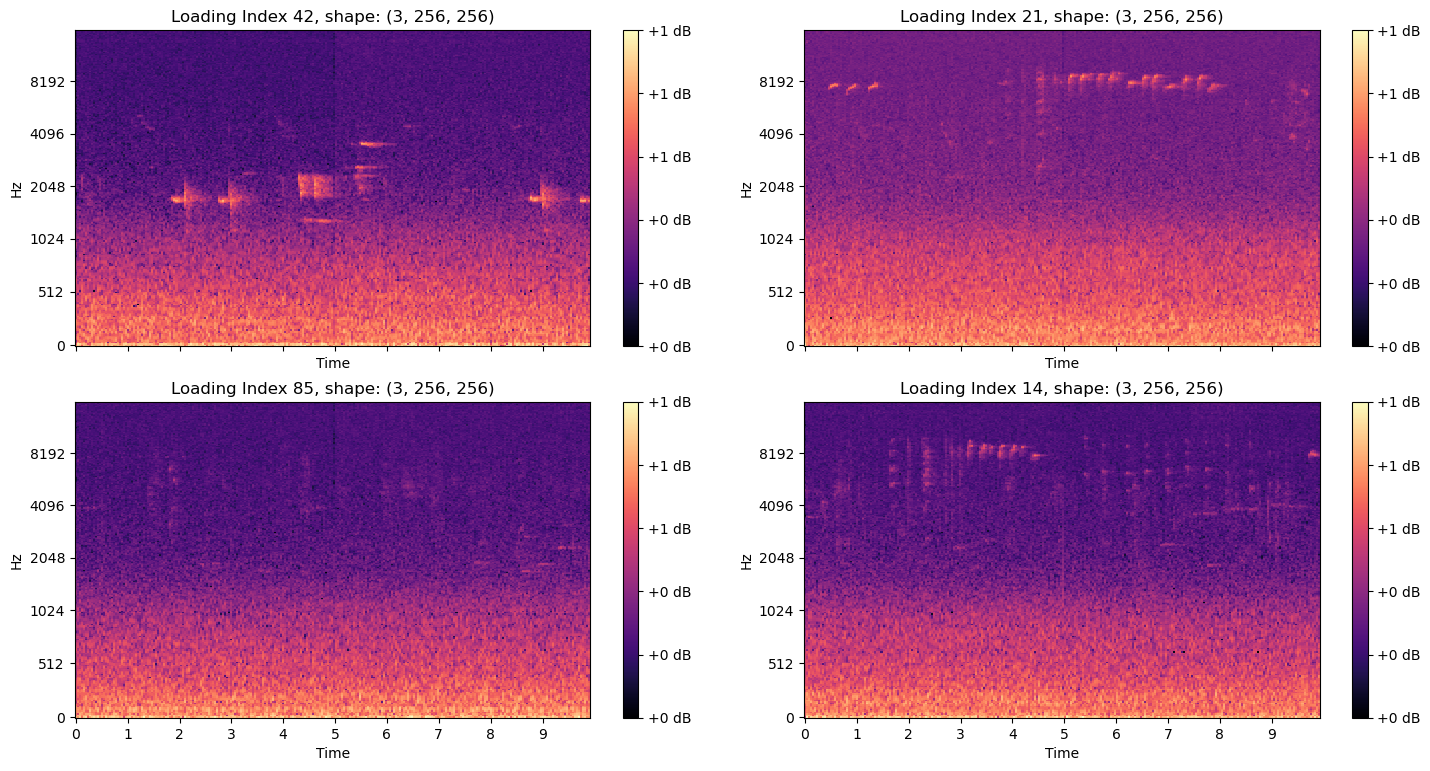

In [285]:
soundscape = random.choice(paths.soundscapes)
image_dict, num_extras = get_images(soundscape, models.parameters[0], audio_params=models.audio)
image_shape = models.parameters[0]['image_shape']
use_deltas = models.parameters[0]['use_deltas']
dataset = ImageDataset(image_dict, image_shape, use_deltas)
show_batch(dataset, models.parameters[0], 2,2)

In [286]:
clip_prediction = prediction_for_clip(random.choice(paths.soundscapes), models=models)
print(f'The shape of the clip predictions array is {clip_prediction.shape}')

Inferring a single soundscape:   0%|          | 0/1 [00:00<?, ?it/s]

The shape of the clip predictions array is (180, 93)


## Prediction in 5 second intervals

In [287]:
test_audios = paths.soundscapes[:2]

In [288]:
prediction_dfs = []
#Note: There is an inherent inefficiency here, if using models that share the same spectrograms, as the spectrogram generation is repeated for each model.
#My assumption is that different models in any ensemble I make will be based on different engineered features for their spectrograms
for idx in range(len(models.models)):
    df = inference(test_audios, models, idx)
    prediction_dfs.append(df)

Overall File List:   0%|          | 0/2 [00:00<?, ?it/s]

Average the various prediction dataframes

In [289]:
prediction_columns = prediction_dfs[0].columns[1:]
values_list = [df[prediction_columns].values for df in prediction_dfs]
average_vals = np.zeros_like(values_list[0])

for array in values_list:
    average_vals = average_vals + array 

average_vals = average_vals / len(values_list)
submission = pd.DataFrame(data=average_vals, columns=prediction_columns)
submission.insert(0, 'row_id', prediction_dfs[0]['row_id']) 

In [290]:
submission.to_csv(paths.PREDICTIONS_CSV, index=False)

In [291]:
pd.read_csv(paths.PREDICTIONS_CSV)

,row_id,ausmag2,auspip3,aussho1,baicra4,blafan1,blbgul1,blfter1,blkswa,bluduc1,...,varoys1,weka1,welswa1,weta,whfter1,whiteh1,x00458,yefpar3,yellow2,yellow3
0,AE142_BIRD_120321_085925_5,0.035746,0.026498,0.000625,0.004072,0.031189,0.005197,0.004764,0.007727,0.003760,...,0.000805,0.062876,0.002415,0.045357,0.007686,0.042577,0.013535,0.007155,0.032762,0.001941
1,AE142_BIRD_120321_085925_10,0.032982,0.023849,0.000588,0.002741,0.027323,0.003960,0.004484,0.006615,0.002837,...,0.000709,0.063886,0.002212,0.047755,0.005821,0.034771,0.012020,0.005317,0.031903,0.001444
2,AE142_BIRD_120321_085925_15,0.030201,0.036662,0.000289,0.011124,0.026119,0.004573,0.014475,0.005747,0.000754,...,0.000535,0.047806,0.003619,0.052118,0.003889,0.071923,0.010702,0.026780,0.061547,0.000753
3,AE142_BIRD_120321_085925_20,0.029988,0.041328,0.000377,0.011690,0.030510,0.005212,0.017456,0.006120,0.000980,...,0.000685,0.051673,0.004730,0.050148,0.004921,0.068788,0.012407,0.028854,0.065333,0.000900
4,AE142_BIRD_120321_085925_25,0.030993,0.021160,0.000261,0.017769,0.022721,0.002860,0.005320,0.005015,0.002074,...,0.000720,0.039840,0.001547,0.033836,0.003160,0.060581,0.003667,0.026746,0.036290,0.001564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,AE142_BIRD_120322_085925_880,0.026440,0.020332,0.001018,0.011922,0.030204,0.019491,0.011942,0.007530,0.007938,...,0.001690,0.120272,0.001633,0.066164,0.011864,0.035445,0.019278,0.011427,0.020569,0.004611
356,AE142_BIRD_120322_085925_885,0.028966,0.015781,0.000472,0.002108,0.022316,0.006301,0.005571,0.003864,0.002123,...,0.000729,0.074181,0.001145,0.078346,0.005129,0.038068,0.015889,0.003701,0.022066,0.001233
357,AE142_BIRD_120322_085925_890,0.023928,0.014258,0.000426,0.002287,0.024161,0.005674,0.005911,0.003023,0.001787,...,0.000799,0.074097,0.000893,0.075119,0.005077,0.034288,0.015186,0.004489,0.019016,0.001430
358,AE142_BIRD_120322_085925_895,0.017834,0.013752,0.000998,0.003382,0.027168,0.004305,0.004529,0.002535,0.001373,...,0.002205,0.093551,0.001472,0.068098,0.004255,0.037195,0.012669,0.008163,0.022995,0.002660
